# Experiment on Synthetic dataset in Paper: Reconstructing ts for BIBM2020


### Layout of this notebook

#### A. TS making and complex noising scheme

#### B. Running two modules in sequeal to reconstruct 




## A. Synthetic Ts and Complex Noising scheme

In [1]:
%matplotlib inline
import numpy as np
import timesynth as ts
import scipy
import matplotlib.pyplot as plt

plt.style.use('ggplot')


In [4]:
# 100 points sampler 
time_sampler = ts.TimeSampler(stop_time=100)
# Sampling regular time samples
regular_time_samples = time_sampler.sample_regular_time(num_points=100)
ar_p = ts.signals.AutoRegressive(ar_param=[1.5, -0.75])
ar_p_series = ts.TimeSeries(signal_generator=ar_p)
samples = ar_p_series.sample(regular_time_samples)

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
### Define the useful standarisation for later usage

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()

In [20]:
### Complex denoising Scheme
### Detailed description, see paper


noise_1 = np.random.laplace(loc = 0, scale = 1.0, size = local_source_signals_4.shape[0])
noise_2 = np.random.gamma(2.,2, size = local_source_signals_4.shape[0])
noise_3 = np.random.beta(a = 5, b = 2, size = local_source_signals_4.shape[0])
noise_4 = np.random.normal(loc = 3, scale = 3, size = local_source_signals_4.shape[0])

noise4 = np.asarray([noise_1, noise_2,noise_3, noise_4])

noise_10 = np.asarray([noise_1[:91], noise_2[:91], noise_3[:91], noise_4[:91], noise_1[:91], 
         noise_2[:91], noise_3[:91], noise_4[:91], noise_1[:91], noise_2[:91]          ]).T

noise4 = noise4.T




(97, 4)

In [29]:
### For comparison, The definition of conventional noise term


noise_global = np.random.laplace(loc = 0, scale = 1.0, size = source_signals.shape)

global_noise = source_signals[:91] + noise_1[:91] + noise_2[:91] + noise_3[:91] + noise_4[:91]

global_noise.shape

(91,)

In [943]:
### The final local noise; complex noise

#final_signals = local_source_signals + noise
final_signals_10 = local_source_signals_10 + noise_10
print (final_signals_10.shape)

(91, 10)


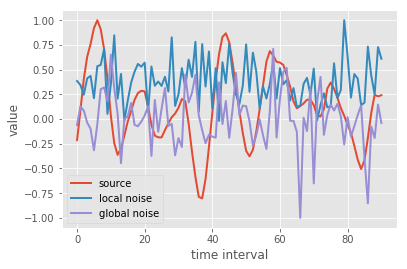

In [1084]:
### Comparison between noises and source signal


plt.plot(max_abs_scaler.fit_transform(np.mean(local_source_signals_10[:91], axis = 1).reshape((-1,1))), 
         label = 'source', linewidth = 2)
#plt.plot(np.mean(local_source_signals[:91], axis = 1), label = 'source-4')
#plt.plot(np.mean(final_signals,axis = 1), label = 'local noised')
plt.plot(max_abs_scaler.fit_transform(np.mean(final_signals_10,axis = 1).reshape((-1,1))), 
         label = 'local noise', linestyle = 'solid', linewidth = 2)
plt.plot(max_abs_scaler.fit_transform(global_noise[:91].reshape((-1,1))), label = 'global noise',
        linestyle = 'solid', linewidth = 2)
#plt.plot(X_norm_4_10_averaged, label = 'first-generation')
#plt.plot(np.mean(final_signals,axis = 1), label = 'local noised-4')
#plt.plot(X_noise_4_10, label = 'noise-4-10')
plt.legend(loc = 'best')
plt.xlabel('time interval')
plt.ylabel('value')
#plt.savefig('surrogate_ts_1.png')

In [1221]:
### The correlation(R) between source and noised ones

scipy.stats.pearsonr(np.mean(local_source_signals_10[:91],axis = 1),
                     np.mean(final_signals_10,axis = 1))

(-0.024263032078192765, 0.8194219106201535)

In [951]:
### For record, R between source and conventional noise term

scipy.stats.pearsonr(source_signals,
                     global_noise)

(0.40349338506510124, 3.146265074371507e-05)

## B. TS reconstruction: Two module running 

In [982]:
## First module


import keras 
from keras import backend as K
import os
import numpy as np
from numpy import load


latent_dim = 1
n_features = 1
def network_encoder(x, latent_dim=latent_dim):
    x = keras.layers.Dense(units= 1, activation = 'linear', name = 'first_layer')(x)
    
    return x
## define the network integrates the information along the sequence
## zt- gar -> ct

def network_autoregressive(x):  ## to get Ct variable via RNN cell; GRU
  
  x = keras.layers.GRU(units = 1, activation='linear',
                       return_sequences=False, name = 'ar_context')(x)
  
  return x

## define mapping Ct -> other z_t+1, z_t+2

def network_prediction(context, latent_dim, predict_terms):
  
  outputs = []
  
  for i in range (predict_terms):
    outputs.append(keras.layers.Dense(units=latent_dim, activation="linear", name='z_t_{i}'.format(i=i))(context))
  if len(outputs) == 1:
        output = keras.layers.Lambda(lambda x: K.expand_dims(x, axis=1))(outputs[0])
  else:
        output = keras.layers.Lambda(lambda x: K.stack(x, axis=1))(outputs)

  return output


In [1050]:
X_shape = (1, )

encoder_input = keras.layers.Input(X_shape)
encoder_output = network_encoder(encoder_input, latent_dim)

encoder_model = keras.models.Model(encoder_input, encoder_output, name = 'encoder')

### Define the autoregressive part model 

terms = 10  ## hyper-parameters for num of previous steps for producing Ct 
predict_terms = 10

x_input = keras.layers.Input((terms, n_features)) ## x_t-3,...,x_t
x_encoded_sequence = keras.layers.TimeDistributed(encoder_model)(x_input) ## z_t-3,...,z_t

context = network_autoregressive(x_encoded_sequence) ## produce Ct variable

preds = network_prediction(context, latent_dim, predict_terms)  ## predict_terms: num of steps for prediction z_t+1,..., z_t+4 prediction based on previous values

y_input = keras.layers.Input((predict_terms, n_features )) ## x_t+1,..., x_t+4
y_encoded = keras.layers.TimeDistributed(encoder_model)(y_input) ## z_t+1,..., z_t+4; true values based on incoming input


dot_product = K.mean(y_encoded * preds, axis = -1)## 
dot_product = K.mean(dot_product, axis = -1, keepdims = True)  ## avearge overall all prediction steps

dot_product_probs = K.sigmoid(dot_product)

loss = dot_product_probs

from keras.models import Model

cpc_extra = Model([x_input, y_input], preds)

cpc_extra.add_loss(loss)
cpc_extra.compile(optimizer ='adam')


history = cpc_extra.fit([final_signals_10[:90].reshape((90,10,1)), final_signals_10[1:91].reshape((90,10,1))], 
                        verbose=0, batch_size=10, epochs=100,
                       shuffle=True, validation_split=0.1)



/usr/local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output lambda_104 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to lambda_104.
  'be expecting any data to be passed to {0}.'.format(name))


In [1051]:
### Getting the Ct;
### Using Ct to reconstruct the TS

Preds_10_linear = []
Contexts_10_linear = []
Embeddings_10_linear = []

get_context_function = K.function([history.model.layers[0].input],
                                         [history.model.layers[2].output])
    
subj_context = get_context_function(final_signals_10)[0]

get_emb_function = K.function([history.model.layers[0].input],
                                         [history.model.layers[1].output])

subj_emb = get_emb_function(final_signals_10)[0]

pred_f = K.function([history.model.layers[0].input],
        [history.model.layers[-1].output])

pred = pred_f(final_signals_10)[0]

Contexts_10_linear.append(subj_context)
Preds_10_linear.append(pred)
Embeddings_10_linear.append(subj_emb)

Preds_10_linear = np.asarray(Preds_10_linear)
Embeddings_10_linear = np.asarray(Embeddings_10_linear)
Contexts_10_linear = np.asarray(Contexts_10_linear)

Contexts_10_linear.shape, Embeddings_10_linear.shape, Preds_10_linear.shape



((1, 91, 1), (1, 91, 10, 1), (1, 91, 10, 1))

In [1054]:
### R between source and first-round

scipy.stats.pearsonr(source_signals[:91],
                     np.mean(np.squeeze(-Preds_10_linear), axis = 1))

(0.4666833993464675, 3.119400503274321e-06)

In [991]:
### Making the common-only TS by averaging two subsequence-wise TSs

X_norm_4 = np.mean(min_max_scaler.fit_transform(np.squeeze(Preds_4_linear)),axis = 1)
X_norm_4_10_averaged = (X_norm_4[:91] + np.squeeze(X_norm))/2


(97,)

In [1059]:
### R between source and Common-only TS

scipy.stats.pearsonr(source_ave,
                     X_norm_4_10_averaged)

(0.5982861676729687, 3.783179713653494e-10)

### Second-round Generation 

In [1087]:
## Inputs: 
X_norm_4[:91].shape, X_norm.shape

((91,), (91, 1))

In [1131]:
from keras import  Model
from keras.layers import  Input,Dense,concatenate,Add
from keras import backend as K

import numpy as np 

In [1132]:
X_input = Input(shape = (1,))
Y_input = Input(shape = (1,))

hl = Dense(1, activation='tanh')(X_input)

hr = Dense(1, activation = 'tanh')(Y_input)

h = Add()([hl, hr])

#decoder

recX = Dense(1, activation='tanh')(h)
recY = Dense(1, activation='tanh')(h)

CorrNet = Model([X_input, Y_input], [recX, recY, h])

In [1133]:
from keras.engine.topology import Layer

class ZeroPadding(Layer):
     def __init__(self, **kwargs):
          super(ZeroPadding, self).__init__(**kwargs)
     def call(self, x, mask=None):
          return K.zeros_like(x) 
     
     def get_output_shape_for(self, input_shape):
          return input_shape

In [1134]:
[recx0,recy0,h0] = CorrNet( [X_input, Y_input])  ## L(zi, g(h(z)))
[recx1,recy1,h1] = CorrNet( [X_input, ZeroPadding()(Y_input)]) #L(z, g(h(x)))
[recx2,recy2,h2] = CorrNet( [ZeroPadding()(X_input), Y_input]) # L(z,g(h(y)))               
H= concatenate([h1,h2]) ##lambda* corr(h(x), h(Y))
model = Model( [X_input,Y_input],[recx0,recx1,recx2,recy0,recy1,recy2,H])

In [1135]:
def correlationLoss(fake,H):
  y1 = H[:,:1]
  y2 = H[:,1:]
  y1_mean = K.mean(y1, axis=0)
  y1_centered = y1 - y1_mean
  y2_mean = K.mean(y2, axis=0)
  y2_centered = y2 - y2_mean
  corr_nr = K.sum(y1_centered * y2_centered, axis=0) 
  corr_dr1 = K.sqrt(K.sum(y1_centered * y1_centered, axis=0) + 1e-8)
  corr_dr2 = K.sqrt(K.sum(y2_centered * y2_centered, axis=0) + 1e-8)
  corr_dr = corr_dr1 * corr_dr2
  corr = corr_nr / corr_dr 
  return K.sum(corr) * 0.01

In [1136]:
model.compile(loss = ['mse', 'mse', 'mse', 
                     'mse', 'mse', 'mse',
                     correlationLoss], optimizer='adam')

In [1137]:
#X_1 = X_norm_4[:91].reshape((-1,1))
#X_2 = X_norm.reshape((-1,1))

model.fit([X_1_noise, X_2_noise],
         [X_1_noise,X_1_noise, X_1_noise, 
          X_2_noise,X_2_noise, X_2_noise,
         np.ones((X_2_noise.shape))], epochs=100,
         verbose=2, shuffle=True, batch_size=30)

Epoch 1/100
 - 5s - loss: 37.4268 - model_109_loss: 7.0688 - concatenate_3_loss: -4.6725e-03
Epoch 2/100
 - 0s - loss: 37.3384 - model_109_loss: 11.7934 - concatenate_3_loss: -4.8791e-03
Epoch 3/100
 - 0s - loss: 37.2539 - model_109_loss: 8.6833 - concatenate_3_loss: -4.5023e-03
Epoch 4/100
 - 0s - loss: 37.1670 - model_109_loss: 7.8633 - concatenate_3_loss: -4.3347e-03
Epoch 5/100
 - 0s - loss: 37.0783 - model_109_loss: 6.3716 - concatenate_3_loss: -5.0962e-03
Epoch 6/100
 - 0s - loss: 36.9941 - model_109_loss: 6.7794 - concatenate_3_loss: -4.9569e-03
Epoch 7/100
 - 0s - loss: 36.9110 - model_109_loss: 10.2243 - concatenate_3_loss: -4.8672e-03
Epoch 8/100
 - 0s - loss: 36.8273 - model_109_loss: 8.3686 - concatenate_3_loss: -4.4818e-03
Epoch 9/100
 - 0s - loss: 36.7374 - model_109_loss: 7.5504 - concatenate_3_loss: -4.8890e-03
Epoch 10/100
 - 0s - loss: 36.6488 - model_109_loss: 7.3656 - concatenate_3_loss: -4.7027e-03
Epoch 11/100
 - 0s - loss: 36.5593 - model_109_loss: 6.2391 - conca

In [1138]:
#shared_representation = CorrNet.predict([X_1, X_2])[2]
common_only_  = CorrNet.predict([X_1_noise, X_2_noise])[2]
#shared_representation.shape

In [1129]:
# R between source and second-round
scipy.stats.pearsonr(source_ave,
                     np.squeeze(sec_gen))

(0.6184239394833282, 6.490940450913118e-11)

In [1130]:
X_1_noise = np.mean(final_signals,axis = 1)[:91] 
X_2_noise = np.mean(final_signals_10,axis = 1)

X_1_noise.shape, X_2_noise.shape

((91,), (91,))

### R among TSs 

In [1140]:
scipy.stats.pearsonr(np.squeeze(common_only),
                     np.squeeze(-sec_gen))

(-0.454692419645333, 5.962763823902925e-06)

In [1141]:
scipy.stats.pearsonr(np.squeeze(common_only),
                     np.squeeze(-X_norm_4_10_averaged))

(-0.5385893775218664, 3.652827646757019e-08)

In [1142]:
scipy.stats.pearsonr(np.squeeze(sec_gen),
                     np.squeeze(-X_norm_4_10_averaged))

(-0.9857990881130314, 9.295909278773207e-71)

In [1235]:
scipy.stats.pearsonr(np.squeeze(max_abs_scaler.fit_transform(np.mean(final_signals_10,axis = 1).reshape((-1,1)))),
                     np.squeeze(source_ave))

(0.05634946225816842, 0.5957441240263294)

In [1231]:
scipy.stats.pearsonr(np.squeeze(max_abs_scaler.fit_transform(np.mean(final_signals_10,axis = 1).reshape((-1,1)))),
                     np.squeeze(-X_norm_4_10_averaged))

(-0.6310080784094433, 2.021134173101961e-11)

In [1236]:
scipy.stats.pearsonr(np.squeeze(max_abs_scaler.fit_transform(np.mean(final_signals_10,axis = 1).reshape((-1,1)))),
                     np.squeeze(-common_only))

(-0.18626706290129305, 0.07709143560211869)

In [1237]:
scipy.stats.pearsonr(np.squeeze(max_abs_scaler.fit_transform(np.mean(final_signals_10,axis = 1).reshape((-1,1)))),
                     np.squeeze(-sec_gen))

(-0.6138660614712622, 9.779688089729877e-11)

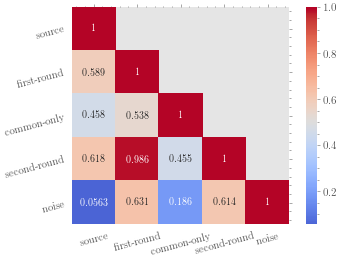

In [1241]:

%matplotlib inline
import matplotlib.pyplot as plt
from heatmap import heatmap, corrplot
import pandas as pd
#plt.style.use('science')
xlabel = ['source','first-round','common-only','second-round', 'noise']
ylabel = ['source','first-round','common-only','second-round', 'noise']

cor_mat = np.array([[1,0.5982, 0.4582, 0.6184,0.0563],
          [0.5892,1,0.5385,0.9857,0.6310 ],
          [0.4582,0.5385,1,0.4546,0.1862],
          [0.6184,0.9857,0.4546,1,0.6138],
          [0.0563,0.6310,0.1862,0.6138,1]])

#mask = np.zeros_like(cor_mat)
#mask[np.triu_indices_from(mask)] = True 
#cor_mat_tri = np.triu(cor_mat)
df = pd.DataFrame(cor_mat)
df_lt = df.where(np.tril(np.ones(cor_mat.shape)).astype(np.bool))
import seaborn as sns
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(df_lt,cmap='coolwarm',annot=True,
                xticklabels=xlabel, yticklabels=ylabel,fmt='.3g',
             square=True,center=0.5)
plt.setp(ax.get_xticklabels(), rotation=15, size = 10.5)
plt.setp(ax.get_yticklabels(), rotation=15, size = 10.5)
#plt.savefig('surrogate_cor_2.png')